# Milestone Pojec 1: Food Vision Big

See the annotated version of this notebook on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/07_food_vision_milestone_project_1.ipynb

## Check GPU

Google Colab offers free GPUs, however, not all of them are compatible with mixed precision training.

Google Colab offer:
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to a Tesla T4 (from within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+ (see here: https://developer.nvidia.com/cuda-gpus)

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1080 (UUID: GPU-34485f07-7e3c-f5a2-f7d8-d14f6ccaef22)


## Get he helper functions

In past modules , we've created a bunch of helper functions to do small taks required for our notebooks.

Rather than rewrite all of these, we can import a script and load them in from there.

The script can be found on GitHub

In [2]:
# Download helper funciton script
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [3]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

If you want to get an overview of TensorFlow Datasets (TFDS), read the guide: https://www.tensorflow.org/datasets/overview

In [5]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

/home/msk/anaconda3/envs/tf/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target dataset in the list of TFDS datasets?

2022-07-19 15:05:17.983364: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


True


In [82]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                            split=["train", "validation"],
                                            shuffle_files=True,
                                            as_supervised=True, # data gets returned in tuple format (data,label),
                                            with_info=True)

In [106]:
len(train_data), len(test_data)

(2368, 790)

## Eploring the Food101 data from TensorFlow Datasets

To become one with our data, we want to find:
* Class names
* The shape of our input data
* The datatype of our input data
* What the labels look like (e.g. are thy one-hot encoded or are they label encoded)
* Do the labels match up with the class names

In [83]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [84]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [85]:
# Take one sample of train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [86]:
# What does one sample of our training dat look like?
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [87]:
# Output info about our training sample
for image, label in train_one_sample:
    print(f"""
    Image Shape: {image.shape},
    Image datatype: {image.dtype},
    Target class from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}
    """)


    Image Shape: (512, 512, 3),
    Image datatype: <dtype: 'uint8'>,
    Target class from Food101 (tensor form): 43
    Class name (str form): fried_calamari
    


In [88]:
# What does our image tensor from TFD's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[71, 60, 56],
        [70, 59, 55],
        [70, 59, 55],
        ...,
        [65, 60, 67],
        [65, 60, 67],
        [64, 59, 66]],

       [[62, 51, 47],
        [64, 53, 49],
        [66, 55, 51],
        ...,
        [65, 60, 67],
        [65, 60, 67],
        [64, 59, 66]],

       [[61, 50, 46],
        [65, 54, 50],
        [68, 57, 53],
        ...,
        [66, 61, 68],
        [65, 60, 67],
        [63, 58, 65]],

       ...,

       [[63, 64, 66],
        [64, 65, 67],
        [67, 67, 69],
        ...,
        [45, 42, 49],
        [45, 42, 49],
        [45, 42, 49]],

       [[64, 64, 66],
        [64, 64, 66],
        [65, 65, 67],
        ...,
        [44, 41, 48],
        [44, 41, 48],
        [44, 41, 48]],

       [[62, 62, 64],
        [62, 62, 64],
        [62, 62, 64],
        ...,
        [43, 40, 47],
        [42, 39, 46],
        [42, 39, 46]]], dtype=uint8)>

In [89]:
# What are the min and my values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Datasets

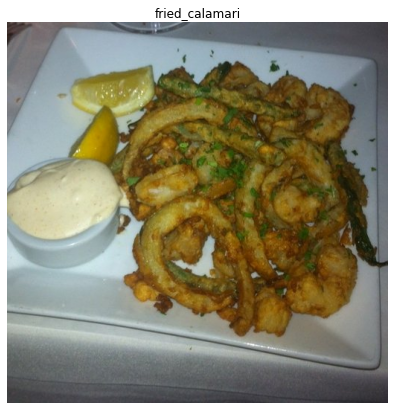

In [90]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is associated with the right image
plt.axis(False)
plt.imshow(image);

## Create preprocessing functions for our data

Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc).

However, not all data (including data from from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:

* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What we know models like:

* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensors generally perform better

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBX pretrained model from tf.keras.applications we don't need to rescale our data (these architectures have rescaling built-in).

This means our functions needs to:

1. Reshape our images to all the same size
2. Convert the dtype of our image tensors from `unit8` to `float32`

In [91]:
# Our data comes in the tuple structure: (image, label)

In [92]:
# Make a function to preprocess our data
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes
    imgage to [image_shape, img_shape, colour_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
    image = tf.cast(image, tf.float32)
    # image =  image/255. # scale image values (not required with EfficientNetBx models from tf.keras.applicaton)
    return image, label # return (float32_image, label) tuple

In [93]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}..., \nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[71 60 56]
  [70 59 55]
  [70 59 55]
  ...
  [65 60 67]
  [65 60 67]
  [64 59 66]]

 [[62 51 47]
  [64 53 49]
  [66 55 51]
  ...
  [65 60 67]
  [65 60 67]
  [64 59 66]]]..., 
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 65.81122   54.811222  50.811222]
  [ 73.331635  62.331635  58.331635]
  [104.015305  89.80102   86.80102 ]
  ...
  [ 61.85712   59.071384  65.64286 ]
  [ 65.        60.        67.      ]
  [ 64.64282   59.642822  66.64282 ]]

 [[ 67.28571   56.285717  52.285717]
  [ 66.47449   55.47449   51.47449 ]
  [ 67.73979   53.525505  50.525505]
  ...
  [ 64.14284   61.3571    67.92857 ]
  [ 65.93368   60.933674  67.93368 ]
  [ 64.285645  59.285645  66.285645]]]..., 
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>


## Batch & prepare datasets

We're now going to make our data input pipeline run really fast.

For more resources on this, I'd highly going through the following guide: https://www.tensorflow.org/guide/data_performance

In [94]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [95]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

> "Hey, TensorFlow, map this preprocessing function (`preprocess_img`) across our training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch."

## Create modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:

* TensorBoard callback to log training results (so we can visualize them later if need be)
* ModelCheckpoint callback to save our model's progress after feature extraction

In [103]:
# Create tensorboard callback (import from helper-functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_chekpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     monitor="val_accuracy",
                                                     save_best_only=True,
                                                     save_weights_only=True,
                                                     verbose=0) # don't print whether or not model is being saved

## Setup mixed precision training

First and foremost, for a deeper understanding of mixed precision training, check out the TensorFlow guide for mixed precision: https://www.tensorflow.org/guide/mixed_precision

Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance.

In [61]:
# Turn on mixed precision training (computability > 7.0)
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

In [63]:
# Set back to default because computeability is < 7.0
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("float32") # set global data policy to mixed precision

In [64]:
mixed_precision.global_policy()

<Policy "float32">

## Build feature extraction model

In [97]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape=(224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False


# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models haverescaling built-in but if your model doesn't you can have a layer like bellow
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # make sure layers which should be in inference mode only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [98]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

## Checking layer dtype policies (are we using mixed precision?)

In [99]:
# Check the dtype_policy attribute of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "float32">
global_average_pooling2d_1 True float32 <Policy "float32">
dense_1 True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:

* `layer.name`: the human readable name of a particular layer
* `layer.trainable`: is the layer trainable or not? (if False, the weights are frozen)
* `layer.dtype`: the data type a layer stores its variables in
* `layer.dtype_policy`: the data type policy a layer computes on its variables with

In [100]:
# Check the dtype_policy attributes of layers in the base model
for layer in model.layers[1].layers[:20]: # check the layers of the base model (layer at index 1 of `model`)
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 False float32 <Policy "float32">
rescaling_1 False float32 <Policy "float32">
normalization_1 False float32 <Policy "float32">
tf.math.truediv_1 False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "float32">
stem_conv False float32 <Policy "float32">
stem_bn False float32 <Policy "float32">
stem_activation False float32 <Policy "float32">
block1a_dwconv False float32 <Policy "float32">
block1a_bn False float32 <Policy "float32">
block1a_activation False float32 <Policy "float32">
block1a_se_squeeze False float32 <Policy "float32">
block1a_se_reshape False float32 <Policy "float32">
block1a_se_reduce False float32 <Policy "float32">
block1a_se_expand False float32 <Policy "float32">
block1a_se_excite False float32 <Policy "float32">
block1a_project_conv False float32 <Policy "float32">
block1a_project_bn False float32 <Policy "float32">
block2a_expand_conv False float32 <Policy "float32">
block2a_expand_bn False float32 <Policy "float32">


In [101]:
mixed_precision.global_policy()

<Policy "float32">

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:

1. Build a feature extraction model (train a couple output layers with base layers frozen)
2. Fine-tune some of the frozen layers

In [104]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                    epochs=3,
                                                    steps_per_epoch=len(train_data),
                                                    validation_data=test_data,
                                                    validation_steps=int(0.15 * len(test_data)),
                                                    callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                          experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                              model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220719-183229
Epoch 1/3
2368/2368 [==============================] - 169s 71ms/step - loss: 1.1495 - accuracy: 0.7016 - val_loss: 1.0175 - val_accuracy: 0.7188
Epoch 2/3
2368/2368 [==============================] - 175s 73ms/step - loss: 1.0225 - accuracy: 0.7313 - val_loss: 0.9822 - val_accuracy: 0.7264
Epoch 3/3
2368/2368 [==============================] - 171s 72ms/step - loss: 0.9368 - accuracy: 0.7528 - val_loss: 0.9652 - val_accuracy: 0.7323


In [105]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 52s 66ms/step - loss: 0.9822 - accuracy: 0.7301


[0.9822210669517517, 0.7301385998725891]

## Off to you...

We've covered a lot of ground so far but since this is a milestone project, it's time for you to takeover.

More specifically, you're challenge is to complete the TEMPLATE version of 07 to obtain a computer vision model (building off the one we've built in this notebook) to beat the DeepFood paper.

In other words, you're going to create Food Vision Big!!!

You can find the TEMPLATE notebook here: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/TEMPLATE_07_food_vision_milestone_project_1.ipynb

And if you get stuck, you can refer to the example version (non-template): https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/07_food_vision_milestone_project_1.ipynb

## Load and evaluate checkpoint weights
We can load in and evaluate our model's checkpoints by:

1. Cloning our model using tf.keras.models.clone_model() to make a copy of our feature extraction model with reset weights.
2. Calling the load_weights() method on our cloned model passing it the path to where our checkpointed weights are stored.
3. Calling evaluate() on the cloned model with loaded weights.


A reminder, checkpoints are helpful for when you perform an experiment such as fine-tuning your model. In the case you fine-tune your feature extraction model and find it doesn't offer any improvements, you can always revert back to the checkpointed version of your model.

In [ ]:
# Clone the model we created (this resets all weights)
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

In [ ]:
# Where are our checkpoints stored?
checkpoint_path

In [ ]:
# Load checkpointed weights into cloned_model
cloned_model.load_weights(checkpoint_path)

Each time you make a change to your model (including loading weights), you have to recompile.

In [ ]:
# Compile cloned_model (with same parameters as original model)
cloned_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
# Evalaute cloned model with loaded weights (should be same score as trained model)
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)

Our cloned model with loaded weight's results should be very close to the feature extraction model's results (if the cell below errors, something went wrong).

In [ ]:
# Loaded checkpoint weights should return very similar results to checkpoint weights prior to saving
import numpy as np
assert np.isclose(results_feature_extract_model, results_cloned_model_with_loaded_weights).all() # check if all elements in array are close

Cloning the model preserves dtype_policy's of layers (but doesn't preserve weights) so if we wanted to continue fine-tuning with the cloned model, we could and it would still use the mixed precision dtype policy.

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in cloned_model.layers[1].layers[:20]: # check only the first 20 layers to save space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

## Save the whole model to file
We can also save the whole model using the `save()` method.

Since our model is quite large, you might want to save it to Google Drive (if you're using Google Colab) so you can load it in for use later.

> 🔑 **Note:** Saving to Google Drive requires mounting Google Drive (go to Files -> Mount Drive).

In [ ]:
# ## Saving model to Google Drive (optional)

# # Create save path to drive 
# save_dir = "drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision/"
# # os.makedirs(save_dir) # Make directory if it doesn't exist

# # Save model
# model.save(save_dir)

We can also save it directly to our Google Colab instance.

> 🔑 **Note:** Google Colab storage is ephemeral and your model will delete itself (along with any other saved files) when the Colab session expires.

In [ ]:
# Save model locally (if you're using Google Colab, your saved model will Colab instance terminates)
save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir)

And again, we can check whether or not our model saved correctly by loading it in and evaluating it.

In [ ]:
# Load model previously saved above
loaded_saved_model = tf.keras.models.load_model(save_dir)

Loading a `SavedModel` also retains all of the underlying layers `dtype_policy` (we want them to be `"mixed_float16"`).

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_saved_model.layers[1].layers[:20]: # check only the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

In [ ]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

In [ ]:
# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
# Note: this will only work if you've instatiated results variables 
import numpy as np
assert np.isclose(results_feature_extract_model, results_loaded_saved_model).all()

That's what we want! Our loaded model performing as it should.

> 🔑 **Note:** We spent a fair bit of time making sure our model saved correctly because training on a lot of data can be time-consuming, so we want to make sure we don't have to continaully train from scratch.

## Preparing our model's layers for fine-tuning

Our feature-extraction model is showing some great promise after three epochs. But since we've got so much data, it's probably worthwhile that we see what results we can get with fine-tuning (fine-tuning usually works best when you've got quite a large amount of data).

Remember our goal of beating the DeepFood paper?

They were able to achieve 77.4% top-1 accuracy on Food101 over 2-3 days of training.

Do you think fine-tuning will get us there?

Let's find out.

To start, let's load in our saved model.

> 🔑 **Note:** It's worth remembering a traditional workflow for fine-tuning is to freeze a pre-trained base model and then train only the output layers for a few iterations so their weights can be updated inline with your custom data (feature extraction). And then unfreeze a number or all of the layers in the base model and continue training until the model stops improving.

Like all good cooking shows, I've saved a model I prepared earlier (the feature extraction model from above) to Google Storage.

We can download it to make sure we're using the same model going forward.

In [ ]:

# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip 

In [ ]:
# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

In [ ]:
# Load and evaluate downloaded GS model
loaded_gs_model = tf.keras.models.load_model("/content/downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [ ]:
# Get a summary of our downloaded model
loaded_gs_model.summary()

And now let's make sure our loaded model is performing as expected.

In [ ]:
# How does the loaded model perform?
results_loaded_gs_model = loaded_gs_model.evaluate(test_data)
results_loaded_gs_model

Great, our loaded model is performing as expected.

When we first created our model, we froze all of the layers in the base model by setting base_model.trainable=False but since we've loaded in our model from file, let's check whether or not the layers are trainable or not.

In [ ]:
# Are any of the layers in our model frozen?
for layer in loaded_gs_model.layers:
  layer.trainable = True # set all layers to trainable
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

Alright, it seems like each layer in our loaded model is trainable. But what if we got a little deeper and inspected each of the layers in our base model?

> 🤔 **Question:** Which layer in the loaded model is our base model?

Before saving the Functional model to file, we created it with five layers (layers below are 0-indexed):

1. The input layer
2. The pre-trained base model layer (tf.keras.applications.EfficientNetB0)
3. The pooling layer
4. The fully-connected (dense) layer
5. The output softmax activation (with float32 dtype)

Therefore to inspect our base model layer, we can access the layers attribute of the layer at index 1 in our model.

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_gs_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

Wonderful, it looks like each layer in our base model is trainable (unfrozen) and every layer which should be using the dtype policy "mixed_policy16" is using it.

Since we've got so much data (750 images x 101 training classes = 75750 training images), let's keep all of our base model's layers unfrozen.

> 🔑 **Note:** If you've got a small amount of data (less than 100 images per class), you may want to only unfreeze and fine-tune a small number of layers in the base model at a time. Otherwise, you risk overfitting.

## A couple more callbacks

We're about to start fine-tuning a deep learning model with over 200 layers using over 100,000 (75k+ training, 25K+ testing) images, which means our model's training time is probably going to be much longer than before.

> 🤔 **Question:** How long does training take?

It could be a couple of hours or in the case of the DeepFood paper (the baseline we're trying to beat), their best performing model took 2-3 days of training time.

You will really only know how long it'll take once you start training.

> 🤔 **Question:** When do you stop training?

Ideally, when your model stops improving. But again, due to the nature of deep learning, it can be hard to know when exactly a model will stop improving.

Luckily, there's a solution: the `EarlyStopping` callback.

The `EarlyStopping` callback monitors a specified model performance metric (e.g. `val_loss`) and when it stops improving for a specified number of epochs, automatically stops training.

Using the EarlyStopping callback combined with the `ModelCheckpoint` callback saving the best performing model automatically, we could keep our model training for an unlimited number of epochs until it stops improving.

Let's set both of these up to monitor our model's `val_loss`.

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

Woohoo! Fine-tuning callbacks ready.

If you're planning on training large models, the `ModelCheckpoint` and `EarlyStopping` are two callbacks you'll want to become very familiar with.

We're almost ready to start fine-tuning our model but there's one more callback we're going to implement: ReduceLROnPlateau.

Remember how the learning rate is the most important model hyperparameter you can tune? (if not, treat this as a reminder).

Well, the `ReduceLROnPlateau` callback helps to tune the learning rate for you.

Like the `ModelCheckpoint` and `EarlyStopping` callbacks, the `ReduceLROnPlateau` callback montiors a specified metric and when that metric stops improving, it reduces the learning rate by a specified factor (e.g. divides the learning rate by 10).

> 🤔 **Question:** Why lower the learning rate?

Imagine having a coin at the back of the couch and you're trying to grab with your fingers.

Now think of the learning rate as the size of the movements your hand makes towards the coin.

The closer you get, the smaller you want your hand movements to be, otherwise the coin will be lost.

Our model's ideal performance is the equivalent of grabbing the coin. So as training goes on and our model gets closer and closer to it's ideal performance (also called **convergence**), we want the amount it learns to be less and less.

To do this we'll create an instance of the `ReduceLROnPlateau` callback to monitor the validation loss just like the `EarlyStopping` callback.

Once the validation loss stops improving for two or more epochs, we'll reduce the learning rate by a factor of 5 (e.g. `0.001` to `0.0002`).

And to make sure the learning rate doesn't get too low (and potentially result in our model learning nothing), we'll set the minimum learning rate to `1e-7`.

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

Learning rate reduction ready to go!

Now before we start training, we've got to recompile our model.

We'll use sparse categorical crossentropy as the loss and since we're fine-tuning, we'll use a 10x lower learning rate than the Adam optimizers default (`1e-4` instead of `1e-3`).

In [ ]:
# Compile the model
loaded_gs_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

Okay, model compiled.

Now let's fit it on all of the data.

We'll set it up to run for up to 100 epochs.

Since we're going to be using the `EarlyStopping` callback, it might stop before reaching 100 epochs.

> 🔑 **Note:** Running the cell below will set the model up to fine-tune all of the pre-trained weights in the base model on all of the Food101 data. Doing so with **unoptimized** data pipelines and **without** mixed precision training will take a fairly long time per epoch depending on what type of GPU you're using (about 15-20 minutes on Colab GPUs). But don't worry, **the code we've written above** will ensure it runs much faster (more like 4-5 minutes per epoch).

In [ ]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = loaded_gs_model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

> **🔑 Note:** If you didn't use mixed precision or use techniques such as prefetch() in the Batch & prepare datasets section, your model fine-tuning probably takes up to 2.5-3x longer per epoch (see the output below for an example).

Results from fine-tuning 🍔👁 Food Vision Big™ on Food101 dataset using an EfficienetNetB0 backbone using a Google Colab Tesla T4 GPU.

Example fine-tuning time for non-prefetched data as well as non-mixed precision training (~2.5-3x longer per epoch).

Let's make sure we save our model before we start evaluating it.

In [ ]:
# # Save model to Google Drive (optional)
# loaded_gs_model.save("/content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/")

In [ ]:
# Save model locally (note: if you're using Google Colab and you save your model locally, it will be deleted when your Google Colab session ends)
loaded_gs_model.save("07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

Looks like our model has gained a few performance points from fine-tuning, let's evaluate on the whole test dataset and see if managed to beat the DeepFood paper's result of 77.4% accuracy.

In [ ]:
# Evaluate mixed precision trained loaded model
results_loaded_gs_model_fine_tuned = loaded_gs_model.evaluate(test_data) 
results_loaded_gs_model_fine_tuned

Woohoo!!!! It looks like our model beat the results mentioned in the DeepFood paper for Food101 (DeepFood's 77.4% top-1 accuracy versus our ~79% top-1 accuracy).

## Download fine-tuned model from Google Storage
As mentioned before, training models can take a significant amount of time.

And again, like any good cooking show, here's something we prepared earlier...

It's a fine-tuned model exactly like the one we trained above but it's saved to Google Storage so it can be accessed, imported and evaluated.

In [ ]:
# Download and evaluate fine-tuned model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip

The downloaded model comes in zip format (`.zip`) so we'll unzip it into the Google Colab instance.

In [ ]:
# Unzip fine-tuned model
!mkdir downloaded_fine_tuned_gs_model # create separate directory for fine-tuned model downloaded from Google Storage
!unzip /content/07_efficientnetb0_fine_tuned_101_classes_mixed_precision -d downloaded_fine_tuned_gs_model

In [ ]:
# Load in fine-tuned model from Google Storage and evaluate
loaded_fine_tuned_gs_model = tf.keras.models.load_model("/content/downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

Finally, we can evaluate our model on the test data (this requires the test_data variable to be loaded.

In [ ]:
# Note: Even if you're loading in the model from Google Storage, you will still need to load the test_data variable for this cell to work
results_downloaded_fine_tuned_gs_model = loaded_fine_tuned_gs_model.evaluate(test_data)
results_downloaded_fine_tuned_gs_model

Excellent! Our saved model is performing as expected (better results than the DeepFood paper!).

Congrautlations! You should be excited! You just trained a computer vision model with competitive performance to a research paper and in far less time (our model took ~20 minutes to train versus DeepFood's quoted 2-3 days).

In other words, you brought Food Vision life!

If you really wanted to step things up, you could try using the EfficientNetB4 model (a larger version of EfficientNetB0). At at the time of writing, the EfficientNet family has the state of the art classification results on the Food101 dataset.

> 📖 **Resource:** To see which models are currently performing the best on a given dataset or problem type as well as the latest trending machine learning research, be sure to check out paperswithcode.com and sotabench.com.

## View training results on TensorBoard
Since we tracked our model's fine-tuning training logs using the TensorBoard callback, let's upload them and inspect them on TensorBoard.dev.

In [ ]:
!tensorboard dev upload --logdir ./training_logs \
  --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
  --description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
  --one_shot

In [ ]:
View experiment: https://tensorboard.dev/experiment/2KINdYxgSgW2bUg7dIvevw/

Viewing at our model's training curves on TensorBoard.dev, it looks like our fine-tuning model gains boost in performance but starts to overfit as training goes on.

See the training curves on TensorBoard.dev here: https://tensorboard.dev/experiment/2KINdYxgSgW2bUg7dIvevw/

To fix this, in future experiments, we might try things like:

* A different iteration of EfficientNet (e.g. EfficientNetB4 instead of EfficientNetB0).
* Unfreezing less layers of the base model and training them rather than unfreezing the whole base model in one go.

In [ ]:
# View past TensorBoard experiments
!tensorboard dev list

In [ ]:
# Delete past TensorBoard experiments
# !tensorboard dev delete --experiment_id YOUR_EXPERIMENT_ID

# Example
!tensorboard dev delete --experiment_id OAE6KXizQZKQxDiqI3cnUQ

-----------------------------------------------------------------------------------------------------------

## test speed of fitting with `image_dataset_from_directory`

In [107]:
train_dir = "data/output/train/"
test_dir = "data/output/val/"

In [108]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_test = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               label_mode="int",
                                                                               image_size=IMG_SIZE)
test_data_test = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode="int",
                                                               image_size=IMG_SIZE,
                                                               shuffle=False) # don't shuffle test data for prediction analysis

Found 80800 files belonging to 101 classes.
Found 20200 files belonging to 101 classes.


In [109]:
len(train_data_test), len(test_data_test)

(2525, 632)

In [111]:
input_shape=(224,224,3)
base_model_test = tf.keras.applications.EfficientNetB0(include_top=False)
base_model_test.trainable = False


# Create functional model
inputs_test = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models haverescaling built-in but if your model doesn't you can have a layer like bellow
# x = preprocessing.Rescaling(1./255)(x)
y = base_model_test(inputs_test, training=False) # make sure layers which should be in inference mode only stay like that
y = layers.GlobalAveragePooling2D()(y)
y = layers.Dense(len(class_names))(y)
outputs_test = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(y)
model_test = tf.keras.Model(inputs_test, outputs_test)

# Compile the model
model_test.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history_test = model.fit(train_data_test,
                          epochs=3,
                          steps_per_epoch=len(train_data_test),
                          validation_data=test_data_test,
                          validation_steps=int(0.15 * len(test_data_test)))

Epoch 1/3
2525/2525 [==============================] - 220s 87ms/step - loss: 0.9190 - accuracy: 0.7544 - val_loss: 0.9948 - val_accuracy: 0.7281
Epoch 2/3
2525/2525 [==============================] - 206s 82ms/step - loss: 0.8336 - accuracy: 0.7764 - val_loss: 1.0172 - val_accuracy: 0.7261
Epoch 3/3
2525/2525 [==============================] - 187s 74ms/step - loss: 0.7783 - accuracy: 0.7922 - val_loss: 1.0470 - val_accuracy: 0.7154
